# Correlogram Analysis

This notebook analyzes the results from correlogram experiments.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Define problem ordering
problem_ordering = [
    'OneMax', 
    #'HelloWorld', 
    'Sphere',
    #'TSP', 
    #'NeuralNetwork',
    'BFS-CNF',
    'BFS-Full', 
    'BFS-EvenParity',
    #'GrammaticalEvolution', 
    ]

## 1. Summary Statistics from Main Results

Read the main CSV results file and create a grouped summary table.

In [30]:
# Read main results file
df = pd.read_csv('outputs/results_2026_01_07_correlogram.csv')
df.head()

,Unnamed: 0,problem,size,size_cat,solver,budget,dist_type,name_type,generator,rep,elapsed,cor_length,onestep_cor,diameter
0,0,OneMax,8,small,correlogram,50,coarse,lin,one-max,0,0.758122,2.306311,0.868464,8.090000
1,1,OneMax,8,small,correlogram,50,coarse,str,one-max,0,0.034239,2.306311,0.868464,8.090000
2,2,OneMax,16,medium,correlogram,200,coarse,lin,one-max,0,0.081013,3.140261,0.814756,15.653333
3,3,OneMax,16,medium,correlogram,200,coarse,str,one-max,0,0.094583,3.140261,0.814756,15.653333
4,4,OneMax,32,large,correlogram,1000,coarse,lin,one-max,0,0.216276,1.390437,0.686635,32.195000


In [31]:
# Create groupby table across problem / size / dist_type / name_type
# Note: The main results file should have columns for diameter, cor_length, and onestep_cor
# If there are multiple reps, we'll aggregate (mean)

groupby_cols = ['problem', 'size', 'dist_type', 'name_type', 'generator']

# Check if diameter is in the dataframe (it might not be if not saved)
# If not, we'll just show cor_length and onestep_cor
if 'diameter' in df.columns:
    summary_cols = ['diameter', 'cor_length', 'onestep_cor']
else:
    summary_cols = ['cor_length', 'onestep_cor']

summary_table = df.groupby(groupby_cols)[summary_cols].mean()

# Apply problem ordering
summary_table = summary_table.reset_index()
summary_table['problem'] = pd.Categorical(summary_table['problem'], categories=problem_ordering, ordered=True)
summary_table = summary_table.sort_values(['problem', 'size', 'dist_type', 'name_type'])
summary_table = summary_table.set_index(groupby_cols)

summary_table

diameter  cor_length  \
problem        size dist_type name_type generator                             
OneMax         8    coarse    lin       one-max        8.090000    2.306311   
                              str       one-max        8.090000    2.306311   
               16   coarse    lin       one-max       15.653333    3.140261   
                              str       one-max       15.653333    3.140261   
               32   coarse    lin       one-max       32.195000    1.390437   
                              str       one-max       32.195000    1.390437   
Sphere         8    coarse    lin       sphere-gen    16.000000    2.250768   
                              str       sphere-gen    16.000000    2.250768   
               16   coarse    lin       sphere-gen    32.000000    3.719734   
                              str       sphere-gen    32.000000    3.719734   
               32   coarse    lin       sphere-gen    64.000000   10.746896   
                              str       sphere-gen    64.000000   10.746896   
BFS-CNF        6    coarse    lin       sr-depth-gen  59.815000    1.684158   
                                        sr-gen        12.114286    6.123101   
                              str       sr-depth-gen  80.610000    2.428158   
                                        sr-gen        13.551429    1.584839   
               9    coarse    lin       sr-depth-gen  61.812000    2.605045   
                                        sr-gen         8.730000    1.703752   
                              str       sr-depth-gen  81.612000    4.417429   
                                        sr-gen         9.565000    1.644451   
               12   coarse    lin       sr-depth-gen  60.030000    2.501422   
                                        sr-gen         7.173333    1.572529   
                              str       sr-depth-gen  80.630000   13.000000   
                                        sr-gen         7.873333    1.572529   
BFS-Full       6    coarse    lin       sr-depth-gen  59.815000    1.714339   
                                        sr-gen        12.114286    5.794645   
                              str       sr-depth-gen  80.610000    1.938369   
                                        sr-gen        13.551429    9.303418   
               9    coarse    lin       sr-depth-gen  61.812000    5.118716   
                                        sr-gen         8.730000    1.678203   
                              str       sr-depth-gen  81.612000    7.635976   
                                        sr-gen         9.565000    1.605533   
               12   coarse    lin       sr-depth-gen  60.030000    5.862385   
                                        sr-gen         7.173333    1.794361   
                              str       sr-depth-gen  80.630000    2.898183   
                                        sr-gen         7.873333    1.794361   
BFS-EvenParity 6    coarse    lin       sr-depth-gen  59.815000   16.953050   
                                        sr-gen        12.114286    2.347746   
                              str       sr-depth-gen  80.610000    2.223023   
                                        sr-gen        13.551429    3.645558   
               9    coarse    lin       sr-depth-gen  61.812000    6.895718   
                                        sr-gen         8.730000    1.307840   
                              str       sr-depth-gen  81.612000    6.140828   
                                        sr-gen         9.565000    1.000000   
               12   coarse    lin       sr-depth-gen  60.030000    2.190983   
                                        sr-gen         7.173333    1.613821   
                              str       sr-depth-gen  80.630000    2.124698   
                                        sr-gen         7.873333    1.613821   

                                                      onestep_cor  
problem        size dist_type name_t

In [32]:
# Save the summary table to CSV
summary_table.to_csv('outputs/correlogram_summary_table.csv')
print("Summary table saved to outputs/correlogram_summary_table.csv")

# Export to LaTeX
latex_str = summary_table.to_latex(float_format="%.3f")
with open('outputs/correlogram_summary_table.tex', 'w') as f:
    f.write(latex_str)
print("Summary table saved to outputs/correlogram_summary_table.tex")

Summary table saved to outputs/correlogram_summary_table.csv
Summary table saved to outputs/correlogram_summary_table.tex


## 2. Plot Correlogram Curves

Read each xy results file and create plots in PDF format.

In [33]:
# Find all xy CSV files
xy_files = glob.glob('outputs/results_2026_01_07_correlogram_xy_*.csv')
print(f"Found {len(xy_files)} xy files to plot")

Found 48 xy files to plot


In [34]:
len(xy_files)

48

In [35]:
sorted(xy_files)

['outputs/results_2026_01_07_correlogram_xy_BFS-CNF_12_large_100000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_12_large_100000_coarse_lin_sr-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_12_large_100000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_12_large_100000_coarse_str_sr-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_6_small_8000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_6_small_8000_coarse_lin_sr-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_6_small_8000_coarse_str_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_6_small_8000_coarse_str_sr-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_9_medium_20000_coarse_lin_sr-depth-gen_rep0.csv',
 'outputs/results_2026_01_07_correlogram_xy_BFS-CNF_9_medium_20000_coarse_lin_sr-gen_rep0.csv',
 'outputs/resu

In [36]:
# Create plots for each xy file and save as PDF
for xy_file in xy_files:
    # Read the xy data
    xy_df = pd.read_csv(xy_file)
    
    # Extract metadata from filename
    # Format: results_2026_01_07_correlogram_xy_{problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_rep{rep}.csv
    filename = Path(xy_file).stem
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Log-scaled marker sizes based on n_axis
    if 'n_axis' in xy_df.columns:
        marker_sizes = np.log10(xy_df['n_axis'] + 1) * 30
    else:
        marker_sizes = 50  # default if n_axis not available
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, edgecolors='black', linewidth=0.5)
    plt.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=1, alpha=0.4, color='gray')
    plt.xlabel('Distance', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.title(filename.replace('results_2026_01_07_correlogram_xy_', '').replace('_', ' '), fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Add legend for marker sizes if n_axis is available
    if 'n_axis' in xy_df.columns:
        from matplotlib.lines import Line2D
        n_min, n_max = xy_df['n_axis'].min(), xy_df['n_axis'].max()
        n_reference = [10, 100, 1000, 10000, 100000]
        n_reference = [n for n in n_reference if n_min <= n <= n_max]
        if len(n_reference) > 0:
            legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor='gray', 
                                      markersize=np.sqrt(np.log10(n+1)*30/np.pi),
                                      label=f'n={n:,}') 
                               for n in n_reference]
            plt.legend(handles=legend_elements, title='Pairs per bin', loc='best', framealpha=0.9, fontsize=9)
        
        # Add text showing range
        plt.text(0.02, 0.98, f'n range: {int(n_min):,}-{int(n_max):,}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top',
                 fontsize=8,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Save as PDF
    pdf_filename = xy_file.replace('.csv', '.pdf')
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.close()
    
print(f"Created {len(xy_files)} PDF plots")

Created 48 PDF plots


## 3. Summary Statistics by Problem Type

Additional analysis grouping by different dimensions.

## 2b. Display Correlogram Plots in Grid

Display all correlogram plots in a grid layout within the notebook.

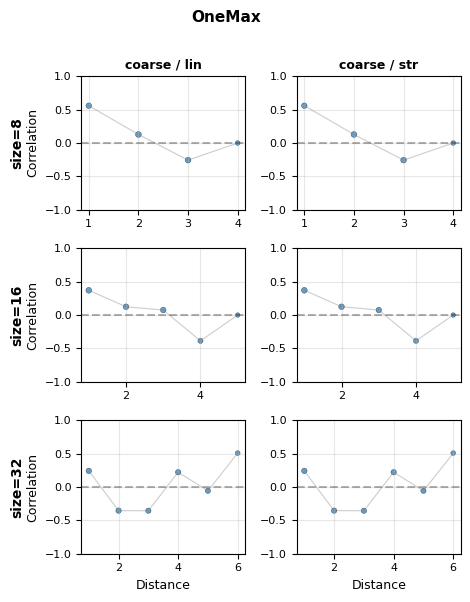

Created grid for OneMax with 3 sizes: [8, 16, 32]


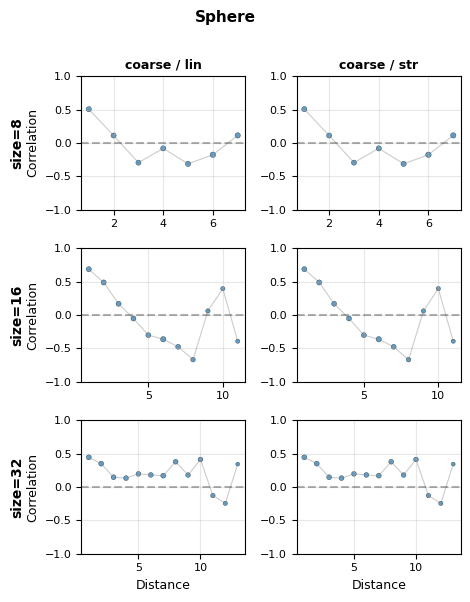

Created grid for Sphere with 3 sizes: [8, 16, 32]


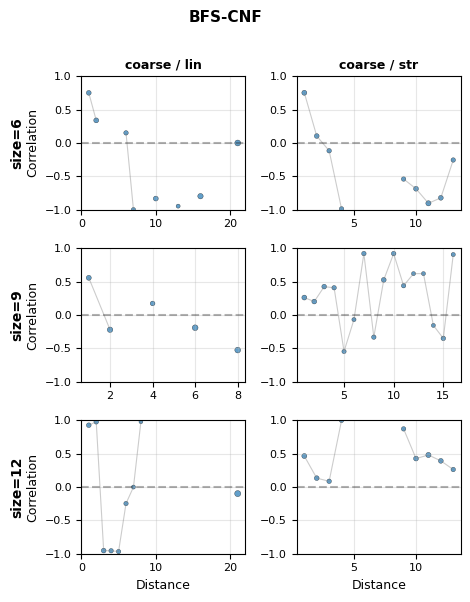

Created grid for BFS-CNF with 3 sizes: [6, 9, 12]


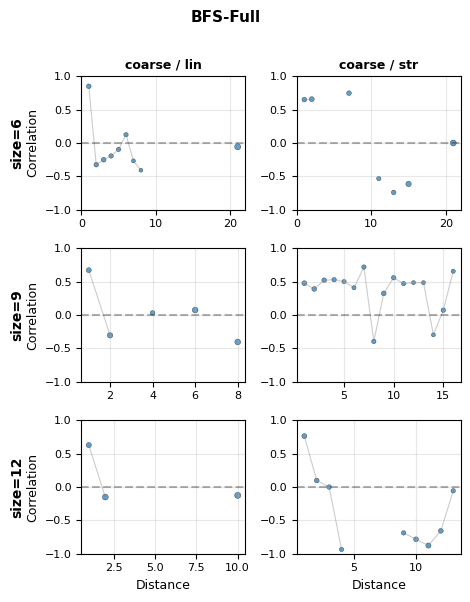

Created grid for BFS-Full with 3 sizes: [6, 9, 12]


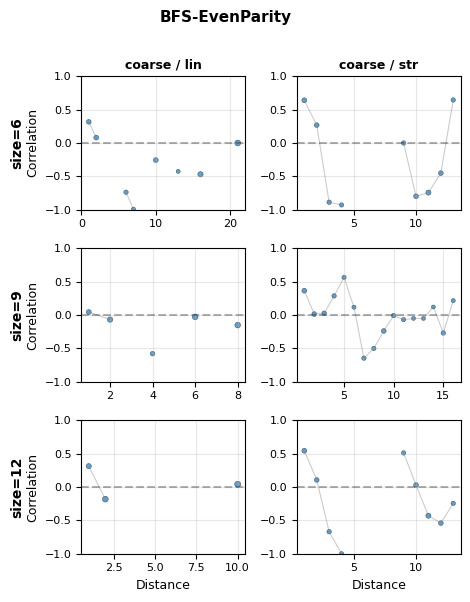

Created grid for BFS-EvenParity with 3 sizes: [6, 9, 12]
Created grids for 5 problems


In [38]:
# Create a grid of plots - one grid per problem
# Within each grid: rows = problem sizes, columns = name_type x dist_type

# Parse filenames to get metadata
plot_data = []
for xy_file in xy_files:
    filename = Path(xy_file).stem
    # Extract parts from filename
    parts = filename.replace('results_2026_01_07_correlogram_xy_', '').split('_')
    
    # Parse: {problem}_{size}_{size_cat}_{budget}_{dist_type}_{name_type}_{generator}_rep{rep}
    try:
        problem = parts[0]
        size = int(parts[1])
        size_cat = parts[2]
        budget = int(parts[3])
        dist_type = parts[4]
        name_type = parts[5]
        generator = parts[6]
        rep = parts[7].replace('rep', '')
        
        plot_data.append({
            'file': xy_file,
            'problem': problem,
            'size': size,
            'size_cat': size_cat,
            'budget': budget,
            'dist_type': dist_type,
            'name_type': name_type,
            'rep': rep
        })
    except:
        print(f"Warning: Could not parse {filename}")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)
plot_df['problem'] = pd.Categorical(plot_df['problem'], categories=problem_ordering, ordered=True)
plot_df = plot_df.sort_values(['problem', 'size', 'dist_type', 'name_type'])

# Get unique problems and combinations
problems = plot_df['problem'].unique()
dist_types = sorted(plot_df['dist_type'].unique())
name_types = sorted(plot_df['name_type'].unique())

# Create column labels for all combinations of dist_type x name_type
columns = [(dt, nt) for dt in dist_types for nt in name_types]

# Create one grid per problem
for problem in problems:
    problem_df = plot_df[plot_df['problem'] == problem]
    
    if len(problem_df) == 0:
        continue
    
    # Get sizes that actually exist for this problem
    sizes = sorted(problem_df['size'].unique())
    
    # Determine grid dimensions
    n_rows = len(sizes)
    n_cols = len(columns)
    
    # Create figure with smaller size - better for papers
    # Each subplot is 2.5" x 2" instead of 5" x 4"
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2*n_rows))
    
    # Handle case of single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{problem}', fontsize=11, fontweight='bold', y=0.995)
    
    # Plot each cell
    for row_idx, size in enumerate(sizes):
        for col_idx, (dist_type, name_type) in enumerate(columns):
            ax = axes[row_idx, col_idx]
            ax.set_ylim(-1, 1)
            
            # Find the matching file
            matching = problem_df[
                (problem_df['size'] == size) & 
                (problem_df['dist_type'] == dist_type) & 
                (problem_df['name_type'] == name_type)
            ]
            
            if len(matching) > 0:
                # Read the xy data
                xy_df = pd.read_csv(matching.iloc[0]['file'])
                
                # Log-scaled marker sizes based on n_axis (smaller for smaller figure)
                if 'n_axis' in xy_df.columns:
                    marker_sizes = np.log10(xy_df['n_axis'] + 1) * 10
                else:
                    marker_sizes = 15
                
                # Plot
                ax.scatter(xy_df['x_axis'], xy_df['y_axis'], s=marker_sizes, alpha=0.7, 
                          edgecolors='black', linewidth=0.3)
                ax.plot(xy_df['x_axis'], xy_df['y_axis'], linestyle='-', linewidth=0.8, 
                       alpha=0.4, color='gray')
            else:
                # No data for this combination (shouldn't happen now, but keep as fallback)
                ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=8, color='gray')
            
            # Formatting
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
            
            # Labels with appropriate font sizes for smaller figure
            if row_idx == n_rows - 1:
                ax.set_xlabel('Distance', fontsize=9)
            if col_idx == 0:
                ax.set_ylabel('Correlation', fontsize=9)
            
            # Tick label sizes
            ax.tick_params(axis='both', labelsize=8)
            
            # Row labels (size)
            if col_idx == 0:
                ax.text(-0.35, 0.5, f'size={size}', transform=ax.transAxes,
                       fontsize=10, va='center', ha='right', fontweight='bold',
                       rotation=90)
            
            # Column labels (dist_type, name_type)
            if row_idx == 0:
                ax.set_title(f'{dist_type} / {name_type}', fontsize=9, fontweight='bold')
    
    plt.tight_layout(rect=[0.03, 0, 1, 0.99])
    plt.savefig(f'outputs/correlogram_grid_{problem}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"Created grid for {problem} with {len(sizes)} sizes: {sizes}")

print(f"Created grids for {len(problems)} problems")

In [39]:
# Group by problem only
by_problem = df.groupby('problem')[summary_cols].mean()
print("\nMean values by problem:")
by_problem


Mean values by problem:


,diameter,cor_length,onestep_cor
problem,,,
BFS-CNF,40.293032,3.403118,0.391726
BFS-EvenParity,40.293032,4.004757,0.293203
BFS-Full,40.293032,3.928207,0.427937
OneMax,18.646111,2.279003,0.789952
Sphere,37.333333,5.572466,0.545923


In [40]:
# Group by size only
by_size = df.groupby('size')[summary_cols].mean()
print("\nMean values by size:")
by_size


Mean values by size:


,diameter,cor_length,onestep_cor
size,,,
6,41.522679,4.645034,0.316723
8,12.045000,2.278539,0.672749
9,40.429750,3.479458,0.355832
12,38.926667,3.211591,0.440310
16,23.826667,3.429998,0.764373
32,48.097500,6.068667,0.566691


In [41]:
# Group by dist_type and name_type
by_type = df.groupby(['dist_type', 'name_type'])[summary_cols].mean()
print("\nMean values by dist_type and name_type:")
by_type


Mean values by dist_type and name_type:


diameter  cor_length  onestep_cor
dist_type name_type                                    
coarse    lin        33.206758    3.875676     0.385182
          str        41.227651    3.755233     0.505219